In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import polynomial_kernel
import statsmodels.formula.api as smf 
import statsmodels.api as sm
from scipy.stats import gaussian_kde
import seaborn as sns
sns.set_theme()
from KSC import KSC

# NSW Experimental Data

In [2]:
# Dehejia-Wahba sample: 185 treated + 260 control units
# outcome of interest "re78" = earnings in 1978 
# pretreatment outcomes "re74" and "re75" = earnings in 1974 and 1975
# covariates: age, education, black, hispanic, married, nodegree
df_dw = pd.read_stata("data/NSW/nsw_dw.dta") 
df_dw = df_dw.drop(columns='data_id')   # (445, 10)

# we add unemployment indicators for future use
# unemployed in 1974 or 1975
df_dw['u74'] = np.where(df_dw['re74']==0, 1, 0)
df_dw['u75'] = np.where(df_dw['re75']==0, 1, 0)

# treatment group
dw_t = df_dw[df_dw['treat']==1] # (185, 12)
N_t = dw_t.shape[0]
Y_t = dw_t['re78'].to_numpy()   # observed outcomes
X_t = dw_t.drop(columns=['treat','re78']).to_numpy()    # (185, 10)
X_t = X_t / np.std(X_t, axis=0, ddof=1)   # standardize 
d = X_t.shape[1]

# control group
dw_c = df_dw[df_dw['treat']==0] # (260, 12)
N_c = dw_c.shape[0]
Y_c = dw_c['re78'].to_numpy()   # observed outcomes
X_c = dw_c.drop(columns=['treat','re78']).to_numpy()    # (260, 10)
X_c = X_c / np.std(X_c, axis=0, ddof=1)  # standardize

print('ATT by mean difference =', np.mean(Y_t) - np.mean(Y_c))

ATT by mean difference = 1794.3433


# Proposed method

In [5]:
# kernel matrices (polynomial)
K_c = polynomial_kernel(X_c, degree=2) # (N_c, N_c)
K_ct = polynomial_kernel(X_c, X_t, degree=2)  # (N_c, N_t)
K_t = polynomial_kernel(X_t, degree=2)  # (N_t, N_t)


# l = 1
# prob = KSC(Kcc=K_c, Kct=K_ct, Ktt=K_t, l=l)
# pi = prob.solve(method='gdkl', tau_scale=100, verbose=True)
# np.save('results/NSW_poly1.npy', pi)

# l = 0.1
# prob = KSC(Kcc=K_c, Kct=K_ct, Ktt=K_t, l=l)
# pi = prob.solve(method='gdkl', tau_scale=200, verbose=True)
# np.save('results/NSW_poly01.npy', pi)

# l = 0.01
# prob = KSC(Kcc=K_c, Kct=K_ct, Ktt=K_t, l=l)
# pi = prob.solve(method='gdkl', tau_scale=200, max_iter=20000, verbose=True)
# np.save('results/NSW_poly001.npy', pi)

# l = 0.001
# prob = KSC(Kcc=K_c, Kct=K_ct, Ktt=K_t, l=l)
# pi = prob.solve(method='gdkl', tau_scale=200, max_iter=30000, verbose=True)
# np.save('results/NSW_poly0001.npy', pi)

Initialization: objective = 9.24760287841873
Implement gradient descent with KL divergence
Iteration 1: objective = 9.053435674938436, objective relative change = -0.020996490229205782, pi change (L1) = 0.021093750844628733
Iteration 2: objective = 8.849074206567177, objective relative change = -0.02257280834688742, pi change (L1) = 0.0213124343863769
Iteration 3: objective = 8.634042973121657, objective relative change = -0.024299856507694215, pi change (L1) = 0.021543188746316264
Iteration 4: objective = 8.409921250823055, objective relative change = -0.025957911374347713, pi change (L1) = 0.021754670646753328
Iteration 5: objective = 8.18107606858608, objective relative change = -0.027211334733316207, pi change (L1) = 0.02189821165007782
Iteration 6: objective = 7.953787900467001, objective relative change = -0.02778218491230348, pi change (L1) = 0.021921171032433337
Iteration 7: objective = 7.7339287838945765, objective relative change = -0.027642064299893555, pi change (L1) = 0.02

In [6]:
# load the saved results
pi_poly001 = np.load('results/NSW_poly001.npy')
pi_poly0001 = np.load('results/NSW_poly0001.npy')

Y_c_poly001 = N_t * Y_c @ pi_poly001
tau_poly001 = Y_t - Y_c_poly001

Y_c_poly0001 = N_t * Y_c @ pi_poly0001
tau_poly0001 = Y_t - Y_c_poly0001

Nearest neighbor matching

In [7]:
Dsq_ct = pairwise_distances(X_c, X_t, metric='sqeuclidean')  # (N_c, N_t)

# 5-nn matching (with replacement)
id_5nn_match = np.argsort(Dsq_ct, axis=0)[:5]
Y_c_5nn = np.mean(Y_c[id_5nn_match], axis=0)
tau_5nn = Y_t - Y_c_5nn

# 10-nn matching (with replacement)
id_10nn_match = np.argsort(Dsq_ct, axis=0)[:10]
Y_c_10nn = np.mean(Y_c[id_10nn_match], axis=0)
tau_10nn = Y_t - Y_c_10nn

print('ATT by 5-NN =', tau_5nn.mean())
print('ATT by 10-NN =', tau_10nn.mean())

ATT by 5-NN = 2030.488
ATT by 10-NN = 1776.6359


Regression

In [8]:
results = smf.ols('re78~age+education+black+hispanic+married+nodegree+re74+re75+u74+u75', data=dw_c).fit()
Y_c_reg = results.predict(dw_t).to_numpy()
tau_reg = Y_t - Y_c_reg
print('ATT by regression =', tau_reg.mean())

ATT by regression = 1706.2035604524867


# PSID Control

In [9]:
df_psid = pd.read_stata('data/NSW/psid_controls.dta')
df_psid = df_psid.drop(columns='data_id')   # (2490, 10)

# unemployed in 1974 or 1975
df_psid['u74'] = np.where(df_psid['re74']==0, 1, 0)
df_psid['u75'] = np.where(df_psid['re75']==0, 1, 0)

N_psid = df_psid.shape[0]
Y_psid = df_psid['re78'].to_numpy()  # observed outcomes
X_psid = df_psid.drop(columns=['treat','re78']).to_numpy()    # (2490, 10)
X_psid = X_psid / np.std(X_psid, axis=0, ddof=1)

print('ATT by mean difference =', np.mean(Y_t) - np.mean(Y_psid))

# pool the Dehejia-Wahba treated sample and the CPS controls
df_t_psid = pd.concat([dw_t, df_psid])

# logistic regression to estimate the propensity score
res_psid = smf.glm(formula="treat~age+I(age**2)+I(age**3)+education+I(education**2)+black+hispanic+married+nodegree+re74+re75+u74+u75+education:re74", data=df_t_psid, family=sm.families.Binomial()).fit()

# estimated propensity scores
ps_t_psid = res_psid.predict(dw_t)
ps_psid = res_psid.predict(df_psid)

# ATT via IPW-Hajek
print('ATT by IPW normalized =', np.mean(Y_t) - np.sum(Y_psid*ps_psid/(1-ps_psid))/np.sum(ps_psid/(1-ps_psid)))

ATT by mean difference = -15204.777
ATT by IPW normalized = 2579.660946046965


# Trimmed PSID Control

In [10]:
# discard values outside of [0.1, 0.9]
id_psid = (ps_psid>=0.05) & (ps_psid<=0.95) # 214 observations out of 2490

df_psid_trim = df_psid[id_psid]
N_psid_trim = df_psid_trim.shape[0]
Y_psid_trim = Y_psid[id_psid]
X_psid_trim = df_psid_trim.drop(columns=['treat','re78']).to_numpy()    # (214, 10)
X_psid_trim = X_psid_trim / np.std(X_psid_trim, axis=0, ddof=1)

ps_psid_trim = ps_psid[id_psid]
w = ps_psid_trim/(1-ps_psid_trim)
w = w.to_numpy()
w = w / np.sum(w)

print('ATT by mean difference =', np.mean(Y_t) - np.mean(Y_psid_trim))
print('ATT by IPW normalized =', np.mean(Y_t) - np.sum(Y_psid_trim*w))

ATT by mean difference = -1373.4272
ATT by IPW normalized = 1748.0036519053538


In [14]:
# kernel matrices (polynomial)
K_psid_trim = polynomial_kernel(X_psid_trim, degree=2)  # (N_psid_trim, N_psid_trim)
K_ct_psid_trim = polynomial_kernel(X_psid_trim, X_t, degree=2)  # (N_psid_trim, N_t)
K_t = polynomial_kernel(X_t, degree=2)  # (N_t, N_t)


# l = 1
# prob = KSC(Kcc=K_psid_trim, Kct=K_ct_psid_trim, Ktt=K_t, l=l, w=w)
# pi = prob.solve(method='gdkl', tau_scale=100, verbose=True)
# np.save('results/PSIDtrim-IPW_poly1.npy', pi)

# l = 0.1
# prob = KSC(Kcc=K_psid_trim, Kct=K_ct_psid_trim, Ktt=K_t, l=l, w=w)
# pi = prob.solve(method='gdkl', tau_scale=200, verbose=True)
# np.save('results/PSIDtrim-IPW_poly01.npy', pi)

# l = 0.01
# prob = KSC(Kcc=K_psid_trim, Kct=K_ct_psid_trim, Ktt=K_t, l=l, w=w)
# pi = prob.solve(method='gdkl', tau_scale=200, verbose=True)
# np.save('results/PSIDtrim-IPW_poly001.npy', pi)

# l = 0.001
# prob = KSC(Kcc=K_psid_trim, Kct=K_ct_psid_trim, Ktt=K_t, l=l, w=w)
# pi = prob.solve(method='gdkl', tau_scale=200, verbose=True)
# np.save('results/PSIDtrim-IPW_poly0001.npy', pi)

Initialization: objective = 8.13804885202466
Implement gradient descent with KL divergence
Iteration 1: objective = 7.996218761302134, objective relative change = -0.017428021544407445, pi change (L1) = 0.023530630478246703
Iteration 2: objective = 7.8526336228731415, objective relative change = -0.01795662959146088, pi change (L1) = 0.023622287368845134
Iteration 3: objective = 7.707764767148602, objective relative change = -0.018448441972711685, pi change (L1) = 0.023689162796827437
Iteration 4: objective = 7.562188150991866, objective relative change = -0.01888700817352395, pi change (L1) = 0.0237145949011005
Iteration 5: objective = 7.416577197424048, objective relative change = -0.019255134976867712, pi change (L1) = 0.023702630588717934
Iteration 6: objective = 7.271698276989993, objective relative change = -0.019534472112603972, pi change (L1) = 0.023635923567979823
Iteration 7: objective = 7.128402309035963, objective relative change = -0.019705983732502326, pi change (L1) = 0.

In [15]:
# load the saved results
pi_poly001_psid_trim = np.load('results/PSIDtrim-IPW_poly001.npy')
pi_poly0001_psid_trim = np.load('results/PSIDtrim-IPW_poly0001.npy')

Y_c_poly001_psid_trim = N_t * Y_psid_trim @ pi_poly001_psid_trim
tau_poly001_psid_trim = Y_t - Y_c_poly001_psid_trim

Y_c_poly0001_psid_trim = N_t * Y_psid_trim @ pi_poly0001_psid_trim
tau_poly0001_psid_trim = Y_t - Y_c_poly0001_psid_trim

In [16]:
Dsq_ct_psid_trim = pairwise_distances(X_psid_trim, X_t, metric='sqeuclidean')  # (N_psid_trim, N_t)

# 5-nn matching (with replacement)
id_5nn_match_psid_trim = np.argsort(Dsq_ct_psid_trim, axis=0)[:5]
Y_c_5nn_psid_trim = np.mean(Y_psid_trim[id_5nn_match_psid_trim], axis=0)
tau_5nn_psid_trim = Y_t - Y_c_5nn_psid_trim

# 10-nn matching (with replacement)
id_10nn_match_psid_trim = np.argsort(Dsq_ct_psid_trim, axis=0)[:10]
Y_c_10nn_psid_trim = np.mean(Y_psid_trim[id_10nn_match_psid_trim], axis=0)
tau_10nn_psid_trim = Y_t - Y_c_10nn_psid_trim

print('ATT by 5-NN =', tau_5nn_psid_trim.mean())
print('ATT by 10-NN =', tau_10nn_psid_trim.mean())

ATT by 5-NN = 1567.254
ATT by 10-NN = 1002.96045


In [17]:
results = smf.ols('re78~age+education+black+hispanic+married+nodegree+re74+re75+u74+u75', data=df_psid_trim).fit()
Y_c_reg_psid_trim = results.predict(dw_t).to_numpy()
tau_reg_psid_trim = Y_t - Y_c_reg_psid_trim
print('ATT by regression =', tau_reg_psid_trim.mean())

ATT by regression = 1065.5402883336735


# Plots

Experimental

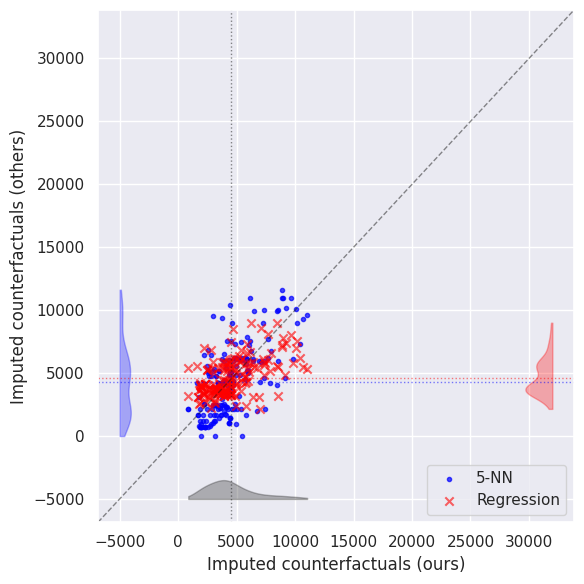

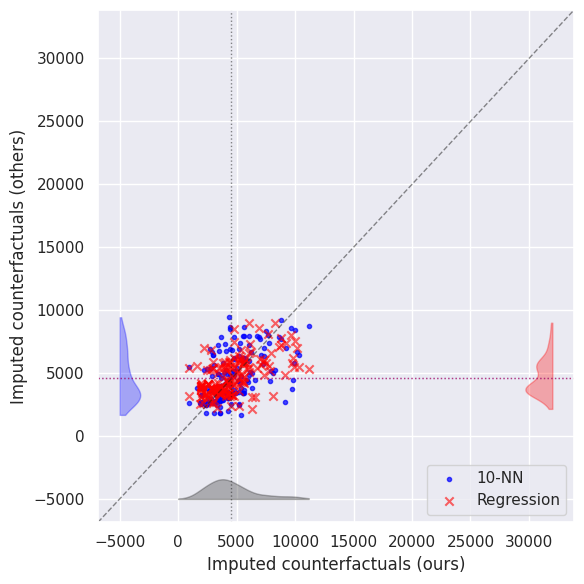

In [18]:
# small lambda
fig = plt.figure(figsize=(6, 6))
plt.scatter(Y_c_poly0001, Y_c_5nn, marker='.', color='blue', alpha=0.7, label='5-NN')
plt.scatter(Y_c_poly0001, Y_c_reg, marker='x', color='red', alpha=0.6, label='Regression')
plt.axline([-3000, -3000], [32000, 32000], color='k', alpha=0.5, linestyle='dashed', linewidth=1)
plt.axvline(Y_c_poly0001.mean(), color='k', alpha=0.5, linestyle='dotted', linewidth=1)
plt.axhline(Y_c_5nn.mean(), color='blue', alpha=0.5, linestyle='dotted', linewidth=1)
plt.axhline(Y_c_reg.mean(), color='red', alpha=0.5, linestyle='dotted', linewidth=1)

# histogram of imputed counterfactuals (ours)
kde_x = gaussian_kde(Y_c_poly0001)
x_vals = np.linspace(Y_c_poly0001.min(), Y_c_poly0001.max(), 100)
kde_x_vals = kde_x(x_vals)
plt.fill_between(x_vals, -5000, kde_x_vals*7000000-5000, alpha=0.3, color='k')

# histogram of imputed counterfactuals (NN)
kde_nn = gaussian_kde(Y_c_5nn)
nn_vals = np.linspace(Y_c_5nn.min(), Y_c_5nn.max(), 100)
kde_nn_vals = kde_nn(nn_vals)
plt.fill_betweenx(nn_vals, -5000, kde_nn_vals*7000000-5000, alpha=0.3, color='blue')

# histogram of imputed counterfactuals (regression)
kde_reg = gaussian_kde(Y_c_reg)
reg_vals = np.linspace(Y_c_reg.min(), Y_c_reg.max(), 100)
kde_reg_vals = kde_reg(reg_vals)
plt.fill_betweenx(reg_vals, 32000-kde_reg_vals*7000000, 32000, alpha=0.3, color='red')

plt.legend()
plt.xlabel('Imputed counterfactuals (ours)')
plt.ylabel('Imputed counterfactuals (others)')
fig.tight_layout()
plt.savefig('figs/NSW_poly0001_imputation.pdf')
plt.show()


# large lambda
fig = plt.figure(figsize=(6, 6))
plt.scatter(Y_c_poly001, Y_c_10nn, marker='.', color='blue', alpha=0.7, label='10-NN')
plt.scatter(Y_c_poly001, Y_c_reg, marker='x', color='red', alpha=0.6, label='Regression')
plt.axline([-3000, -3000], [32000, 32000], color='k', alpha=0.5, linestyle='dashed', linewidth=1)
plt.axvline(Y_c_poly001.mean(), color='k', alpha=0.5, linestyle='dotted', linewidth=1)
plt.axhline(Y_c_10nn.mean(), color='blue', alpha=0.5, linestyle='dotted', linewidth=1)
plt.axhline(Y_c_reg.mean(), color='red', alpha=0.5, linestyle='dotted', linewidth=1)

# histogram of imputed counterfactuals (ours)
kde_x = gaussian_kde(Y_c_poly001)
x_vals = np.linspace(0, Y_c_poly001.max(), 100)
kde_x_vals = kde_x(x_vals)
plt.fill_between(x_vals, -5000, kde_x_vals*7000000-5000, alpha=0.3, color='k')

# histogram of imputed counterfactuals (NN)
kde_nn = gaussian_kde(Y_c_10nn)
nn_vals = np.linspace(Y_c_10nn.min(), Y_c_10nn.max(), 100)
kde_nn_vals = kde_nn(nn_vals)
plt.fill_betweenx(nn_vals, -5000, kde_nn_vals*7000000-5000, alpha=0.3, color='blue')

# histogram of imputed counterfactuals (regression)
kde_reg = gaussian_kde(Y_c_reg)
reg_vals = np.linspace(Y_c_reg.min(), Y_c_reg.max(), 100)
kde_reg_vals = kde_reg(reg_vals)
plt.fill_betweenx(reg_vals, 32000-kde_reg_vals*7000000, 32000, alpha=0.3, color='red')

plt.legend()
plt.xlabel('Imputed counterfactuals (ours)')
plt.ylabel('Imputed counterfactuals (others)')
fig.tight_layout()
plt.savefig('figs/NSW_poly001_imputation.pdf')
plt.show()

In [19]:
print('std of imputed counterfactuals (lambda = 0.001) =', np.std(Y_c_poly0001, ddof=1))
print('std of imputed counterfactuals (lambda = 0.01) =', np.std(Y_c_poly001, ddof=1))

std of imputed counterfactuals (lambda = 0.001) = 2131.509986491617
std of imputed counterfactuals (lambda = 0.01) = 2063.0401000332304


PSID_trim

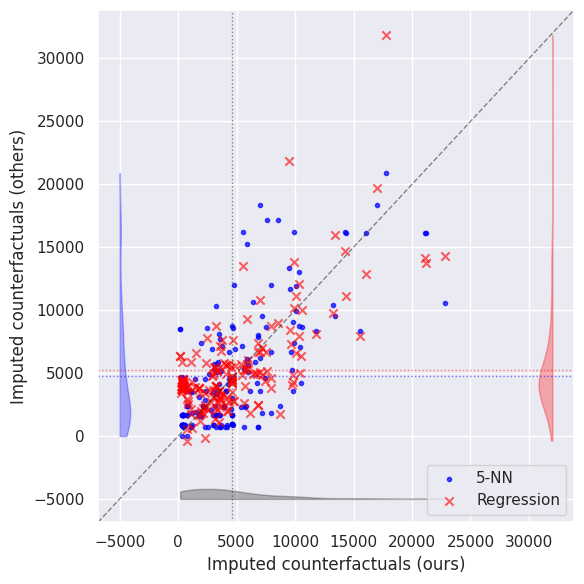

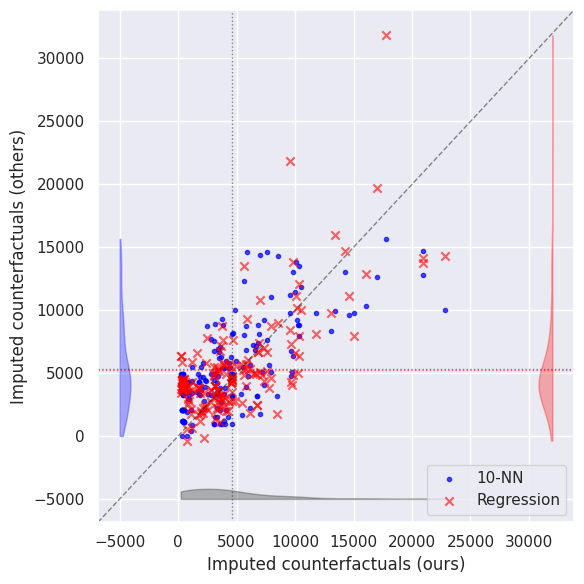

In [20]:
# small lambda
fig = plt.figure(figsize=(6, 6))
plt.scatter(Y_c_poly0001_psid_trim, Y_c_5nn_psid_trim, marker='.', color='blue', alpha=0.7, label='5-NN')
plt.scatter(Y_c_poly0001_psid_trim, Y_c_reg_psid_trim, marker='x', color='red', alpha=0.6, label='Regression')
plt.axline([-3000, -3000], [32000, 32000], color='k', alpha=0.5, linestyle='dashed', linewidth=1)
plt.axvline(Y_c_poly0001_psid_trim.mean(), color='k', alpha=0.5, linestyle='dotted', linewidth=1)
plt.axhline(Y_c_5nn_psid_trim.mean(), color='blue', alpha=0.5, linestyle='dotted', linewidth=1)
plt.axhline(Y_c_reg_psid_trim.mean(), color='red', alpha=0.5, linestyle='dotted', linewidth=1)

# histogram of imputed counterfactuals (ours)
kde_x = gaussian_kde(Y_c_poly0001_psid_trim)
x_vals = np.linspace(Y_c_poly0001_psid_trim.min(), Y_c_poly0001_psid_trim.max(), 100)
kde_x_vals = kde_x(x_vals)
plt.fill_between(x_vals, -5000, kde_x_vals*7000000-5000, alpha=0.3, color='k')

# histogram of imputed counterfactuals (NN)
kde_nn = gaussian_kde(Y_c_5nn_psid_trim)
nn_vals = np.linspace(Y_c_5nn_psid_trim.min(), Y_c_5nn_psid_trim.max(), 100)
kde_nn_vals = kde_nn(nn_vals)
plt.fill_betweenx(nn_vals, -5000, kde_nn_vals*7000000-5000, alpha=0.3, color='blue')

# histogram of imputed counterfactuals (regression)
kde_reg = gaussian_kde(Y_c_reg_psid_trim)
reg_vals = np.linspace(Y_c_reg_psid_trim.min(), Y_c_reg_psid_trim.max(), 100)
kde_reg_vals = kde_reg(reg_vals)
plt.fill_betweenx(reg_vals, 32000-kde_reg_vals*7000000, 32000, alpha=0.3, color='red')


plt.legend()
plt.xlabel('Imputed counterfactuals (ours)')
plt.ylabel('Imputed counterfactuals (others)')
fig.tight_layout()
plt.savefig('figs/PSIDtrim-IPW_poly0001_imputation.pdf')
plt.show()


# large lambda
fig = plt.figure(figsize=(6, 6))
plt.scatter(Y_c_poly001_psid_trim, Y_c_10nn_psid_trim, marker='.', color='blue', alpha=0.7, label='10-NN')
plt.scatter(Y_c_poly001_psid_trim, Y_c_reg_psid_trim, marker='x', color='red', alpha=0.6, label='Regression')
plt.axline([-3000, -3000], [32000, 32000], color='k', alpha=0.5, linestyle='dashed', linewidth=1)
plt.axvline(Y_c_poly001_psid_trim.mean(), color='k', alpha=0.5, linestyle='dotted', linewidth=1)
plt.axhline(Y_c_10nn_psid_trim.mean(), color='blue', alpha=0.5, linestyle='dotted', linewidth=1)
plt.axhline(Y_c_reg_psid_trim.mean(), color='red', alpha=0.5, linestyle='dotted', linewidth=1)

# histogram of imputed counterfactuals (ours)
kde_x = gaussian_kde(Y_c_poly001_psid_trim)
x_vals = np.linspace(Y_c_poly001_psid_trim.min(), Y_c_poly001_psid_trim.max(), 100)
kde_x_vals = kde_x(x_vals)
plt.fill_between(x_vals, -5000, kde_x_vals*7000000-5000, alpha=0.3, color='k')

# histogram of imputed counterfactuals (NN)
kde_nn = gaussian_kde(Y_c_10nn_psid_trim)
nn_vals = np.linspace(Y_c_10nn_psid_trim.min(), Y_c_10nn_psid_trim.max(), 100)
kde_nn_vals = kde_nn(nn_vals)
plt.fill_betweenx(nn_vals, -5000, kde_nn_vals*7000000-5000, alpha=0.3, color='blue')

# histogram of imputed counterfactuals (regression)
kde_reg = gaussian_kde(Y_c_reg_psid_trim)
reg_vals = np.linspace(Y_c_reg_psid_trim.min(), Y_c_reg_psid_trim.max(), 100)
kde_reg_vals = kde_reg(reg_vals)
plt.fill_betweenx(reg_vals, 32000-kde_reg_vals*7000000, 32000, alpha=0.3, color='red')


plt.legend()
plt.xlabel('Imputed counterfactuals (ours)')
plt.ylabel('Imputed counterfactuals (others)')
fig.tight_layout()
plt.savefig('figs/PSIDtrim-IPW_poly001_imputation.pdf')
plt.show()

In [21]:
print('std of imputed counterfactuals (lambda = 0.001) =', np.std(Y_c_poly0001_psid_trim, ddof=1))
print('std of imputed counterfactuals (lambda = 0.01) =', np.std(Y_c_poly001_psid_trim, ddof=1))

std of imputed counterfactuals (lambda = 0.001) = 4330.516279253384
std of imputed counterfactuals (lambda = 0.01) = 4301.216915144958
